In [1]:
import time
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import math
import sys
import os
sys.path.append("/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Experiments/Analysis")
from Generate_data_activity import Generate_data
from Manifold_Analysis import Manifold_analysis
from CCA_analysis import CCA_Analysis
sys.path.append("/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif")

from algos.agents import A2CAgent
from algos.models import ActorCnn, CriticCnn
from algos.preprocessing.stack_frame import preprocess_frame, stack_frame

# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.cross_decomposition import CCA
import pandas as pd
import seaborn as sns
import cv2
from tabulate import tabulate
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.text import Annotation
import matplotlib.pyplot as plt    
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import warnings
from scipy.sparse import (spdiags, SparseEfficiencyWarning, csc_matrix,
    csr_matrix, isspmatrix, dok_matrix, lil_matrix, bsr_matrix)
warnings.simplefilter('ignore',SparseEfficiencyWarning)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


Device:  cpu


In [2]:
class Annotation3D(Annotation):
    '''Annotate the point xyz with text s'''

    def __init__(self, s, xyz, *args, **kwargs):
        Annotation.__init__(self,s, xy=(0,0), *args, **kwargs)
        self._verts3d = xyz        

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.xy=(xs,ys)
        Annotation.draw(self, renderer)
        
        

def annotate3D(ax, s, *args, **kwargs):
    '''add anotation text s to to Axes3d ax'''

    tag = Annotation3D(s, *args, **kwargs)
    ax.add_artist(tag)    

# Generate Data with A2C model

In [ ]:
LENGTH_TRIAL = 500
EPISODES = 10

Generate_DATA = Generate_data(device)
Liste_activation,Final_score,Liste_position_agent,Liste_position_alien,Liste_action_agent= Generate_DATA.run_episodes(structure_network = "a2c",length_trial = LENGTH_TRIAL,number_episode = EPISODES)

## Preprocessing

In [53]:
Names_hook = ["Conv_1","Conv_2","Conv_3","fc1"]
analysis = Manifold_analysis(LENGTH_TRIAL)
Prepro_length = True
activity_layer = [[[[] for i in range(len(Names_hook))] for j in range(6)] for episode in range(EPISODES)]

for agent_number in range(6):
    print(agent_number)
    for layer in range(len(Names_hook)):
        for episode in range(EPISODES):
            activity_layer[episode][agent_number][layer] = analysis.prepro(Liste_activation[episode][agent_number][layer],Prepro_length)

0
1
2
3
4
5


## Selection of the episode, agent and layer to study

In [84]:
episode = 0
agent = 2
layer = 2

# PCA Analysis

## PCA of the data

In [85]:
X = np.transpose(activity_layer[episode][agent][layer])
pca = PCA(n_components = 5) #we have 20 features
pca.fit(X)        

PCA(n_components=5)

## Representation of the first two components

xn = pca.components_[0]
yn = pca.components_[1]
zn = pca.components_[2]

group = Liste_action_agent[episode][agent][0:500]
group_label = ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

#purple= 1 // blue= 2// cyan = 3 //green = 4 // yellow =5 
xyzn = list(zip(xn, yn, zn))
segments = [(xyzn[s], xyzn[s+1]) for s in range(len(pca.components_[1])-1)]                
# create figure        
fig = plt.figure(figsize=(80, 60),dpi=120)
ax = plt.gca(projection='3d')
ax.set_axis_off()
# plot vertices
ax.scatter(xn,yn,zn, marker='o', c = group, s = 64)    
# plot edges
edge_col = Line3DCollection(segments, lw=0.2)
ax.add_collection3d(edge_col)
# add vertices annotation.
for j, xyz_ in enumerate(xyzn): 
    annotate3D(ax, s=str(Liste_position_alien[0][0][j]), xyz=xyz_, fontsize=20, xytext=(-3,3),
               textcoords='offset points', ha='right',va='bottom')    


# CCA Analysis

# Correlation between PCA components and latent variables

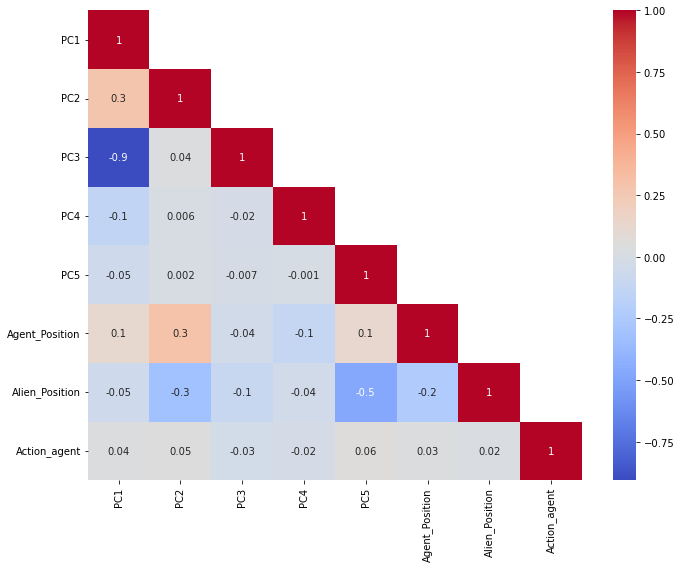

In [86]:
corr_df= cca_analysis.df.corr(method='pearson') 

plt.figure(figsize=(10,8))
X_df_lt = corr_df.where(np.tril(np.ones(corr_df.shape)).astype(np.bool))
sns.heatmap(X_df_lt,cmap="coolwarm",annot=True,fmt='.1g')
plt.tight_layout()
plt.savefig("Heatmap_Canonical_Correlates_from_X_and_data.jpg",
                    format='jpeg',
                    dpi=100)


## Comparison of the PCA components with the Alien Position

In [100]:
Liste_table_X = ['PC1','PC2','PC3','PC4','PC5']
Liste_table_Y = ["Alien_Position","Agent_Position"]

cca_analysis = CCA_Analysis(Liste_table_X,Liste_table_Y,LENGTH_TRIAL,activity_layer[episode][agent_number][layer],Liste_position_agent[episode][agent_number],Liste_position_alien[episode][agent_number],Liste_action_agent[episode][agent_number])

print("The correlation between the first pair of canonical variables is :",cca_analysis.coeff_corr_first_pair)
print("The correlation between the second pair of canonical variables is :",cca_analysis.coeff_corr_second_pair)

The correlation between the first pair of canonical variables is : 0.6752199526270121
The correlation between the second pair of canonical variables is : nan


/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:252: FutureWarning: As of version 0.24, n_components(500) should be in [1, min(n_features, n_samples, n_targets)] = [1, 2]. n_components=2 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  FutureWarning,


## Comparison of the PCA components with the Agent Position

In [88]:
Liste_table_X = ['PC1','PC2','PC3','PC4','PC5']
Liste_table_Y = ["Agent_Position"]

cca_analysis = CCA_Analysis(Liste_table_X,Liste_table_Y,LENGTH_TRIAL,activity_layer[episode][agent_number][layer],Liste_position_agent[episode][agent_number],Liste_position_alien[episode][agent_number],Liste_action_agent[episode][agent_number])

print("The correlation between the first pair of canonical variables is :",cca_analysis.coeff_corr_first_pair)
print("The correlation between the second pair of canonical variables is :",cca_analysis.coeff_corr_second_pair)

The correlation between the first pair of canonical variables is : 0.3601352743328422
The correlation between the second pair of canonical variables is : nan


/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:252: FutureWarning: As of version 0.24, n_components(500) should be in [1, min(n_features, n_samples, n_targets)] = [1, 1]. n_components=1 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  FutureWarning,


# Correlation between components 3 and 4 and alien position

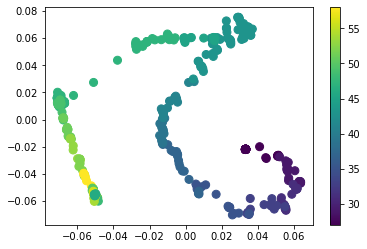

In [92]:

plt.figure()
plt.scatter(pca.components_[1],pca.components_[4], marker='o', c = Liste_position_alien[episode][agent_number][0:500], s = 64) 
plt.colorbar()
#plt.scatter(pca.components_[3],pca.components_[4])

/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:252: FutureWarning: As of version 0.24, n_components(500) should be in [1, min(n_features, n_samples, n_targets)] = [1, 1]. n_components=1 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:252: FutureWarning: As of version 0.24, n_components(500) should be in [1, min(n_features, n_samples, n_targets)] = [1, 1]. n_components=1 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:252: FutureWarning: As of version 0.24, n_components(500) should be in [1, min(n_features, n_samples, n_targets)] = [1, 1]. n_components=1 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  FutureWarning,
/opt/an

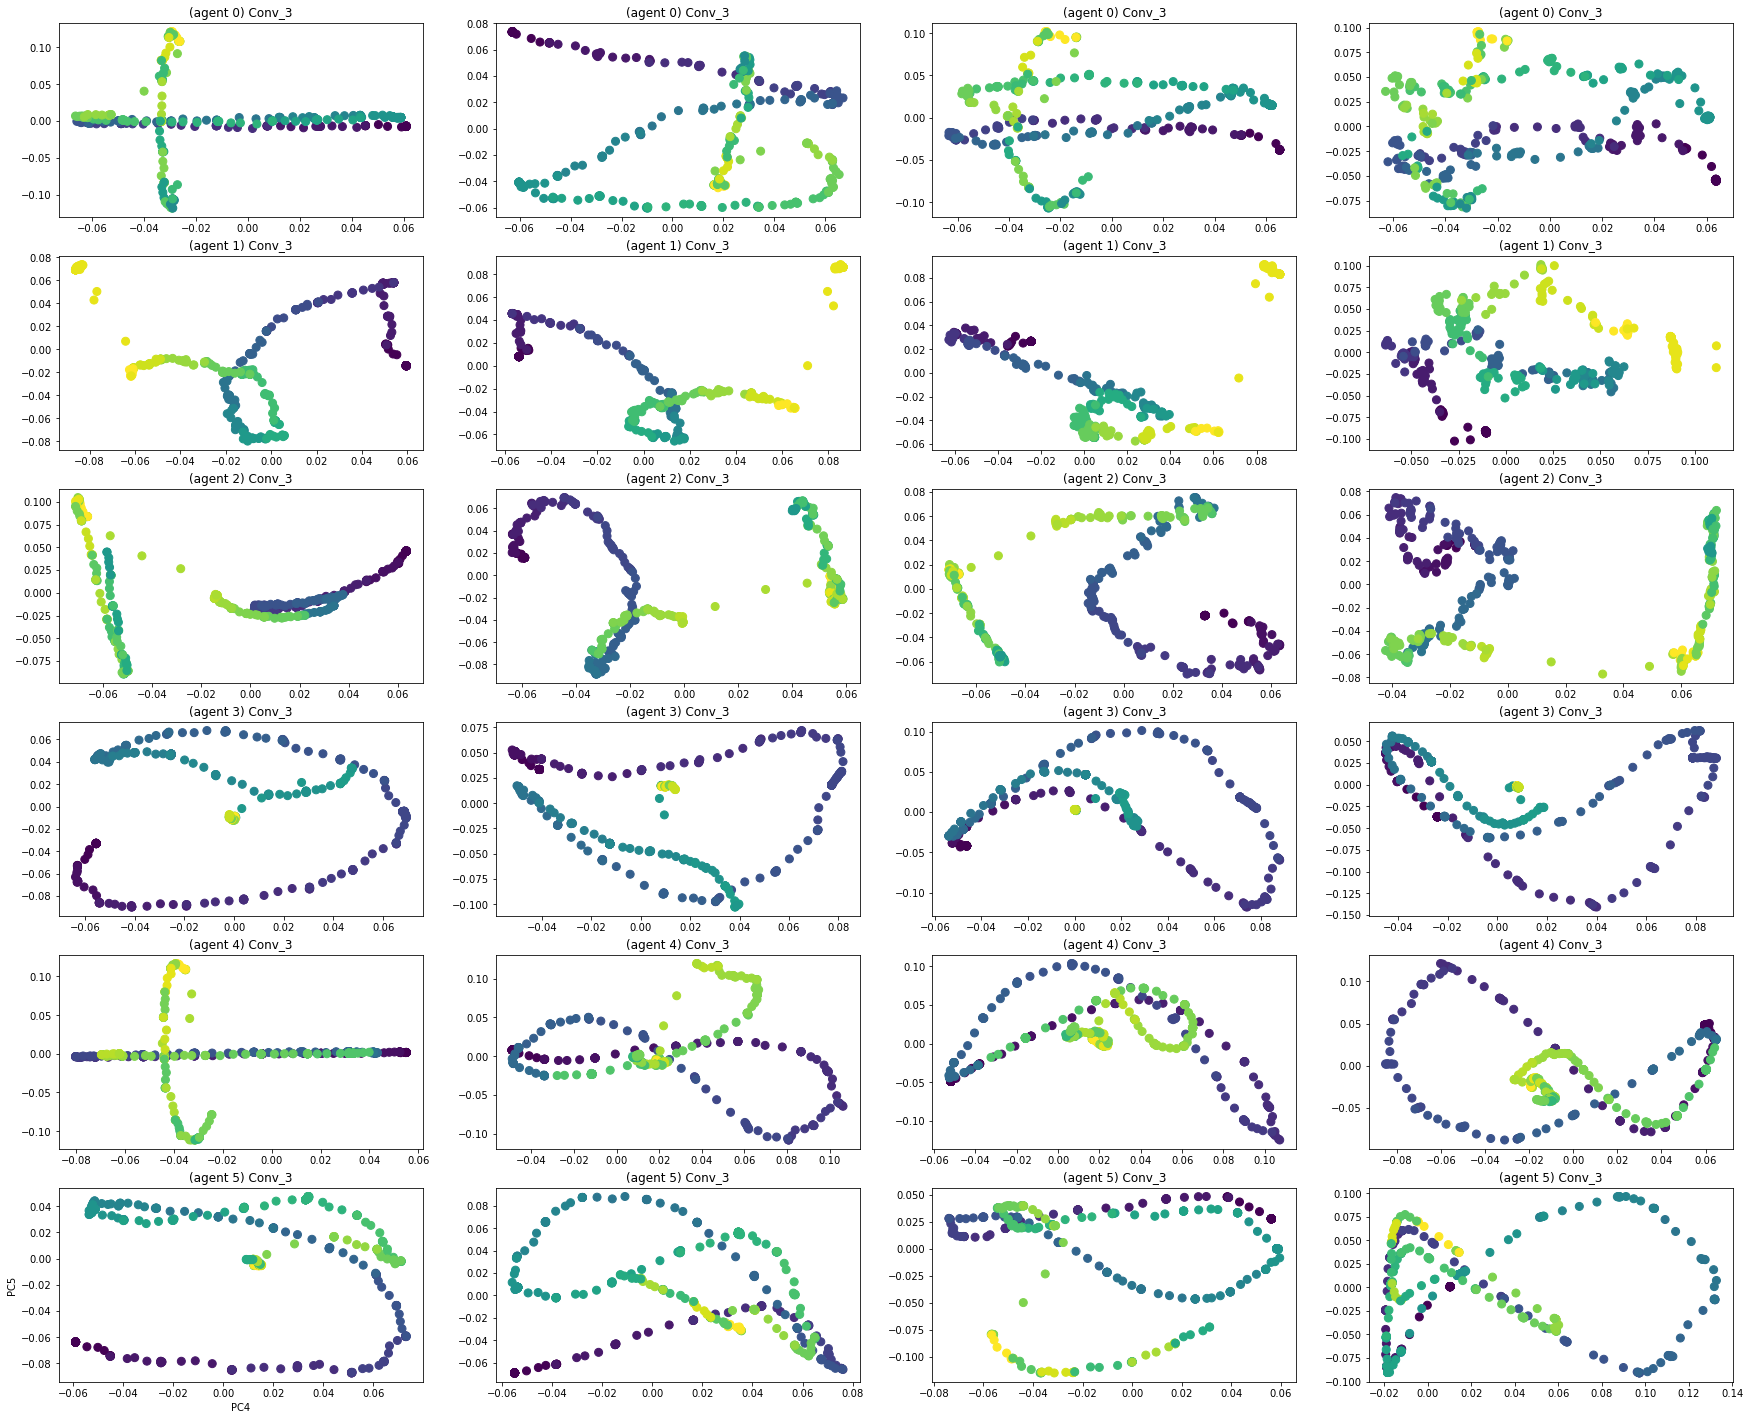

In [97]:
j=1
fig = plt.figure(figsize=(30,25))
for agent_number in range(6):
    for i in range(len(Names_hook)):
        cca_analysis = CCA_Analysis(Liste_table_X,Liste_table_Y,LENGTH_TRIAL,activity_layer[episode][agent_number][i],Liste_position_agent[episode][agent_number],Liste_position_alien[episode][agent_number],Liste_action_agent[episode][agent_number])
        ax = fig.add_subplot(6,len(Names_hook),j)
        ax.scatter(cca_analysis.pca.components_[1],cca_analysis.pca.components_[4], marker='o', c = Liste_position_alien[episode][agent_number][0:500], s = 64) 
        ax.set_title("(agent %s) %s" % (agent_number, Names_hook[layer]))           # plt.suptitle(table[agent_number][0], fontsize=20)
        if i ==0 and agent_number== 5 :
            ax.set_xlabel('PC4')
            ax.set_ylabel('PC5')
            
        j+=1

# Impact of the training on the correlation

In [65]:

Liste_table_X = ['PC4','PC5']
Liste_table_Y = ["Alien_Position"]
table = [["Init"],["1000"],["2000"],["3000"],["4000"],["5000"]]


for agent_number in range(6):
    for i in range(len(Names_hook)):
        liste = []
        for episode in range(EPISODES):
            cca_analysis = CCA_Analysis(Liste_table_X,Liste_table_Y,LENGTH_TRIAL,activity_layer[episode][agent_number][i],Liste_position_agent[episode][agent_number],Liste_position_alien[episode][agent_number],Liste_action_agent[episode][agent_number])
            liste.append(cca_analysis.coeff_corr_first_pair)
        table[agent_number].append(np.mean(liste)) 
    table[agent_number].append(np.mean(Final_score[agent_number]))    
 

/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:252: FutureWarning: As of version 0.24, n_components(500) should be in [1, min(n_features, n_samples, n_targets)] = [1, 1]. n_components=1 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:252: FutureWarning: As of version 0.24, n_components(500) should be in [1, min(n_features, n_samples, n_targets)] = [1, 1]. n_components=1 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:252: FutureWarning: As of version 0.24, n_components(500) should be in [1, min(n_features, n_samples, n_targets)] = [1, 1]. n_components=1 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  FutureWarning,
/opt/an

In [66]:
print(tabulate(table, headers=["# Training Epoch","Conv_1","Conv_2","Conv_3","fc1","Average Score"],tablefmt ="fancy_grid"))

╒════════════════════╤══════════╤══════════╤══════════╤══════════╤═════════════════╕
│ # Training Epoch   │   Conv_1 │   Conv_2 │   Conv_3 │      fc1 │   Average Score │
╞════════════════════╪══════════╪══════════╪══════════╪══════════╪═════════════════╡
│ Init               │ 0.515294 │ 0.595126 │ 0.487205 │ 0.430606 │         174.167 │
├────────────────────┼──────────┼──────────┼──────────┼──────────┼─────────────────┤
│ 1000               │ 0.280604 │ 0.329742 │ 0.502167 │ 0.701858 │         183.333 │
├────────────────────┼──────────┼──────────┼──────────┼──────────┼─────────────────┤
│ 2000               │ 0.461302 │ 0.499676 │ 0.632491 │ 0.668566 │         137.5   │
├────────────────────┼──────────┼──────────┼──────────┼──────────┼─────────────────┤
│ 3000               │ 0.540955 │ 0.525386 │ 0.572486 │ 0.506877 │         151.667 │
├────────────────────┼──────────┼──────────┼──────────┼──────────┼─────────────────┤
│ 4000               │ 0.547521 │ 0.737157 │ 0.313895 │ 0.353347 

/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:252: FutureWarning: As of version 0.24, n_components(500) should be in [1, min(n_features, n_samples, n_targets)] = [1, 1]. n_components=1 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:252: FutureWarning: As of version 0.24, n_components(500) should be in [1, min(n_features, n_samples, n_targets)] = [1, 1]. n_components=1 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:252: FutureWarning: As of version 0.24, n_components(500) should be in [1, min(n_features, n_samples, n_targets)] = [1, 1]. n_components=1 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  FutureWarning,
/opt/an

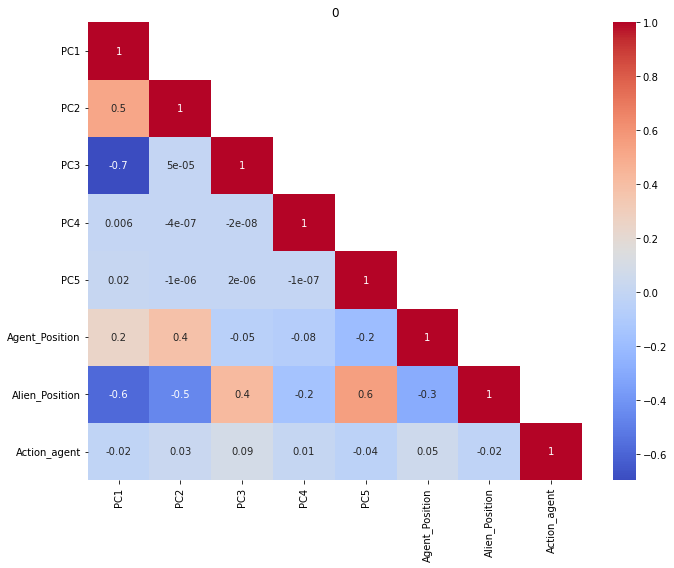

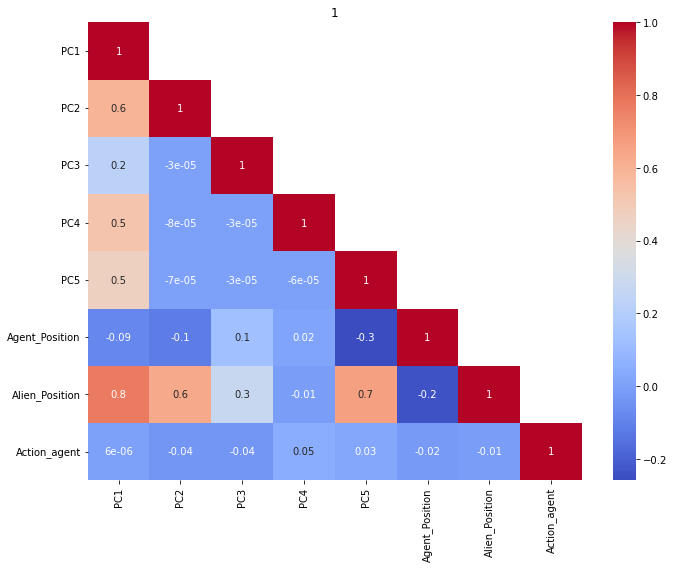

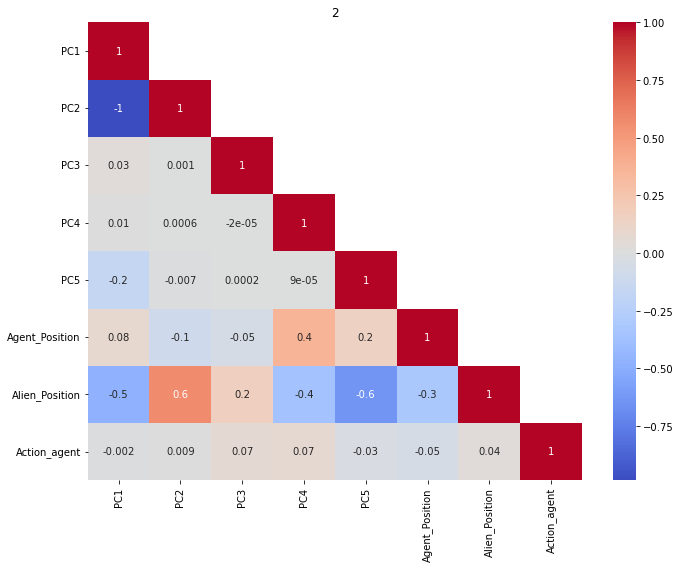

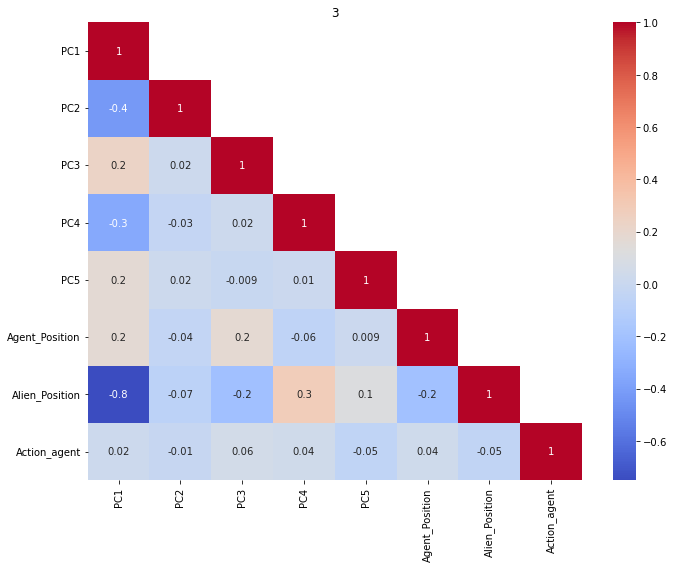

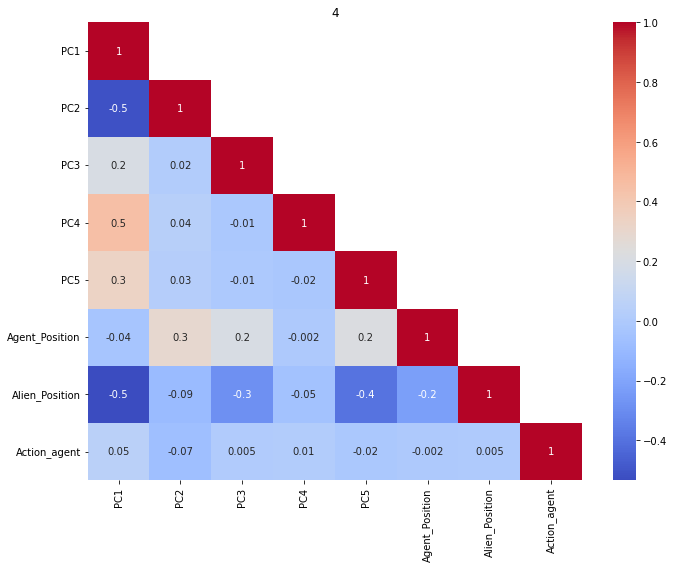

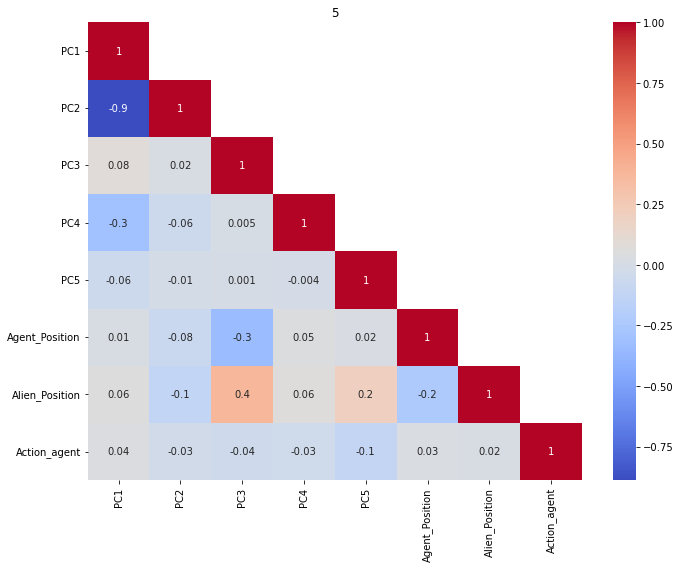

In [96]:
for agent_number in range(6):
    cca_analysis = CCA_Analysis(Liste_table_X,Liste_table_Y,LENGTH_TRIAL,activity_layer[episode][agent_number][i],Liste_position_agent[episode][agent_number],Liste_position_alien[episode][agent_number],Liste_action_agent[episode][agent_number])
    corr_df= cca_analysis.df.corr(method='pearson') 
    plt.figure(figsize=(10,8))
    X_df_lt = corr_df.where(np.tril(np.ones(corr_df.shape)).astype(np.bool))
    sns.heatmap(X_df_lt,cmap="coolwarm",annot=True,fmt='.1g')
    plt.title(agent_number)
    plt.tight_layout()
  